In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
import mahotas
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew, entropy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import skimage
from skimage import io, exposure, morphology, filters, color, segmentation, feature, measure, img_as_float, img_as_ubyte, transform
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem Preprocessed'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc_aug= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel_aug= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc_aug= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
train_bcc = []
train_mel = []
train_scc = []
for bcc in train_bcc_aug:
  if 'aug' not in bcc:
    train_bcc.append(bcc)
for mel in train_mel_aug:
  if 'aug' not in mel:
    train_mel.append(mel)
for scc in train_scc_aug:
  if 'aug' not in scc:
    train_scc.append(scc)

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

1993
2713
376
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
class LBP:
  def __init__(self, points, radius):
    self.points= points
    self.radius= radius
  def compute(self,image,e=1e-08):
    lbp_feature= feature.local_binary_pattern(image, self.points, self.radius, method="uniform")
    (lbp_histogram,_)= np.histogram(lbp_feature.ravel(), bins=np.arange(0, self.points + 3))

    #Normalization of the histogram
    lbp_histogram= lbp_histogram.astype("float")
    lbp_histogram /= (lbp_histogram.sum()+e)

    return lbp_histogram

In [ ]:
def LBP_feature_extractor(images_routes):
  lbp_histograms1=[]
  lbp_histograms2=[]
  lbp_histograms3=[]
  mean_histograms1=[]
  mean_histograms2=[]
  mean_histograms3=[]
  std_histograms1=[]
  std_histograms2=[]
  std_histograms3=[]
  kurtosis_histograms1=[]
  kurtosis_histograms2=[]
  kurtosis_histograms3=[]
  skew_histograms1=[]
  skew_histograms2=[]
  skew_histograms3=[]
  entropy_histograms1=[]
  entropy_histograms2=[]
  entropy_histograms3=[]
  lbp_object1= LBP(8,1)
  lbp_object2= LBP(16,2)
  lbp_object3= LBP(24,3)
  for i in images_routes:
    img= cv2.imread(i)
    img_bw= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    lbp_hist1=lbp_object1.compute(img_bw)
    lbp_hist2=lbp_object2.compute(img_bw)
    lbp_hist3=lbp_object3.compute(img_bw)
    mean_histograms1.append(np.mean(lbp_hist1))
    mean_histograms2.append(np.mean(lbp_hist2))
    mean_histograms3.append(np.mean(lbp_hist3))

    std_histograms1.append(np.std(lbp_hist1))
    std_histograms2.append(np.std(lbp_hist2))
    std_histograms3.append(np.std(lbp_hist3))

    kurtosis_histograms1.append(kurtosis(lbp_hist1))
    kurtosis_histograms2.append(kurtosis(lbp_hist2))
    kurtosis_histograms3.append(kurtosis(lbp_hist3))

    skew_histograms1.append(skew(lbp_hist1))
    skew_histograms2.append(skew(lbp_hist2))
    skew_histograms3.append(skew(lbp_hist3))

    entropy_histograms1.append(entropy(lbp_hist1))
    entropy_histograms2.append(entropy(lbp_hist2))
    entropy_histograms3.append(entropy(lbp_hist3))

    lbp_histograms1.append(lbp_hist1)
    lbp_histograms2.append(lbp_hist2)
    lbp_histograms3.append(lbp_hist3)

  LBP_features1= pd.DataFrame(data= lbp_histograms1)
  LBP_features2= pd.DataFrame(data= lbp_histograms2)
  LBP_features3= pd.DataFrame(data= lbp_histograms3)

  LBP_Statistics1= {'mean': mean_histograms1, 'std':std_histograms1, 'kurtosis': kurtosis_histograms1, 'skew': skew_histograms1, 'entropy': entropy_histograms1}
  LBP_Statistics2= {'mean': mean_histograms2, 'std':std_histograms2, 'kurtosis': kurtosis_histograms2, 'skew': skew_histograms2, 'entropy': entropy_histograms2}
  LBP_Statistics3= {'mean': mean_histograms3, 'std':std_histograms3, 'kurtosis': kurtosis_histograms3, 'skew': skew_histograms3, 'entropy': entropy_histograms3}

  LBP_statistics1_result= pd.DataFrame.from_dict(LBP_Statistics1)
  LBP_statistics2_result= pd.DataFrame.from_dict(LBP_Statistics2)
  LBP_statistics3_result= pd.DataFrame.from_dict(LBP_Statistics3)


  return LBP_features1, LBP_features2, LBP_features3, LBP_statistics1_result, LBP_statistics2_result, LBP_statistics3_result

In [ ]:
LBP_features1_train, LBP_features2_train, LBP_features3_train, LBP_statistics1_result_train, LBP_statistics2_result_train, LBP_statistics3_result_train= LBP_feature_extractor(X_train)
LBP_features1_test, LBP_features2_test, LBP_features3_test, LBP_statistics1_result_test, LBP_statistics2_result_test, LBP_statistics3_result_test= LBP_feature_extractor(X_test)

In [ ]:
LBP_features1_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_features1_train_291022.csv',index=False)
LBP_features2_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_features2_train_291022.csv',index=False)
LBP_features3_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_LBP_features3_train_291022.csv',index=False)
LBP_statistics1_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics1_result_train_291022.csv',index=False)
LBP_statistics2_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics2_result_train_291022.csv',index=False)
LBP_statistics3_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics3_result_train_291022.csv',index=False)

LBP_features1_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_features1_test_291022.csv',index=False)
LBP_features2_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_features2_test_291022.csv',index=False)
LBP_features3_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_features3_test_291022.csv',index=False)
LBP_statistics1_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics1_result_test_291022.csv',index=False)
LBP_statistics2_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics2_result_test_291022.csv',index=False)
LBP_statistics3_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/smote_LBP_statistics3_result_test_29022.csv',index=False)

In [ ]:
LBP_histogram_features_train= pd.concat([LBP_features1_train, LBP_features2_train, LBP_features3_train], axis=1)
LBP_histogram_features_test= pd.concat([LBP_features1_test, LBP_features2_test, LBP_features3_test], axis=1)

In [ ]:
LBP_statistics_features_train= pd.concat([LBP_statistics1_result_train,LBP_statistics2_result_train, LBP_statistics3_result_train], axis=1)
LBP_statistics_features_test= pd.concat([LBP_statistics1_result_test,LBP_statistics2_result_test, LBP_statistics3_result_test], axis=1)

In [ ]:
X_train_features= LBP_histogram_features_train
X_test_features= LBP_histogram_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
#Data Balancing in order to tackle data imbalance. technique used: SMOTE 
ros = SMOTE(sampling_strategy='auto', random_state= 42)
X_train_resampled, y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
print(np.bincount(y_train_resampled))

[2713 2713 2713]


First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_resampled, y_train_resampled)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.83      0.63      0.72       678
           1       0.68      0.61      0.64       498
           2       0.15      0.50      0.24        94

    accuracy                           0.61      1270
   macro avg       0.55      0.58      0.53      1270
weighted avg       0.72      0.61      0.65      1270

0.5810617099667105


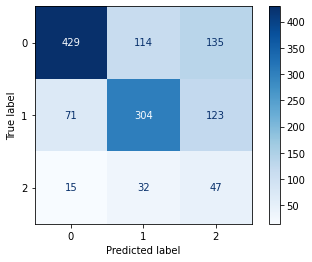

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_resampled, y_train_resampled)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       678
           1       0.68      0.59      0.63       498
           2       0.16      0.51      0.25        94

    accuracy                           0.63      1270
   macro avg       0.56      0.59      0.54      1270
weighted avg       0.73      0.63      0.67      1270

0.5908333011957451


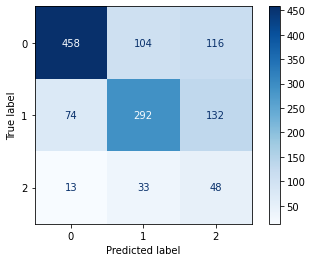

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_resampled, y_train_resampled)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73       678
           1       0.64      0.62      0.63       498
           2       0.19      0.44      0.27        94

    accuracy                           0.63      1270
   macro avg       0.54      0.58      0.54      1270
weighted avg       0.69      0.63      0.65      1270

0.5760922305931188


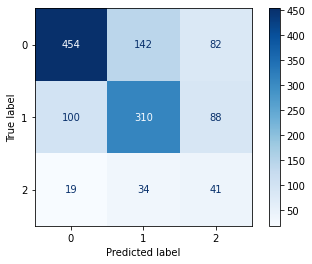

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_resampled, y_train_resampled)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       678
           1       0.66      0.65      0.65       498
           2       0.21      0.27      0.24        94

    accuracy                           0.68      1270
   macro avg       0.55      0.56      0.55      1270
weighted avg       0.68      0.68      0.68      1270

0.5554103692747517


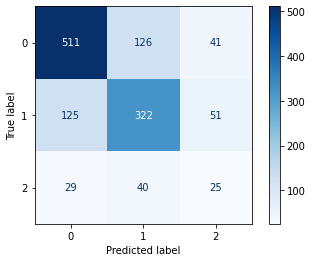

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_resampled, y_train_resampled)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       678
           1       0.61      0.53      0.57       498
           2       0.15      0.48      0.23        94

    accuracy                           0.57      1270
   macro avg       0.51      0.54      0.49      1270
weighted avg       0.66      0.57      0.60      1270

0.5373629079803808


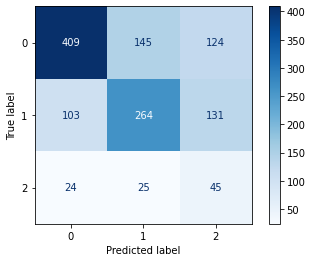

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_resampled, y_train_resampled)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       678
           1       0.55      0.56      0.55       498
           2       0.15      0.26      0.19        94

    accuracy                           0.57      1270
   macro avg       0.47      0.48      0.47      1270
weighted avg       0.61      0.57      0.59      1270

0.4816068390804163


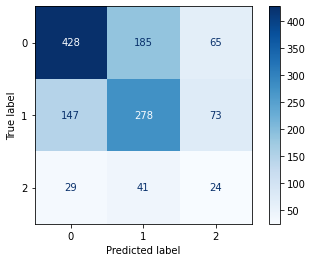

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_resampled, y_train_resampled)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       678
           1       0.63      0.61      0.62       498
           2       0.15      0.36      0.21        94

    accuracy                           0.61      1270
   macro avg       0.52      0.54      0.51      1270
weighted avg       0.67      0.61      0.63      1270

0.5380899736522189


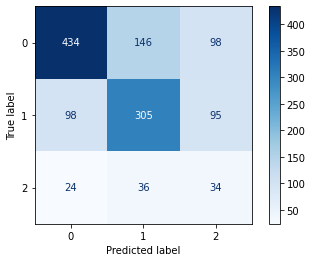

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_resampled, y_train_resampled)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.74      0.28      0.40       678
           1       0.56      0.46      0.50       498
           2       0.10      0.62      0.17        94

    accuracy                           0.37      1270
   macro avg       0.46      0.45      0.36      1270
weighted avg       0.62      0.37      0.42      1270

0.4508906144883305


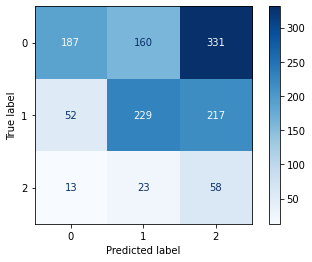

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_resampled, y_train_resampled)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.77      0.62      0.68       678
           1       0.61      0.53      0.57       498
           2       0.15      0.47      0.23        94

    accuracy                           0.57      1270
   macro avg       0.51      0.54      0.49      1270
weighted avg       0.66      0.57      0.60      1270

0.538733229535225


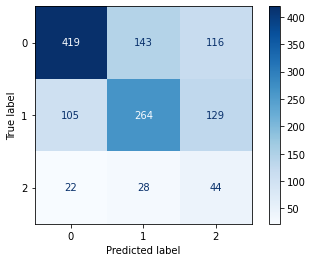

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_resampled, y_train_resampled)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       678
           1       0.63      0.63      0.63       498
           2       0.19      0.30      0.23        94

    accuracy                           0.65      1270
   macro avg       0.53      0.55      0.54      1270
weighted avg       0.68      0.65      0.66      1270

0.5487582666068781


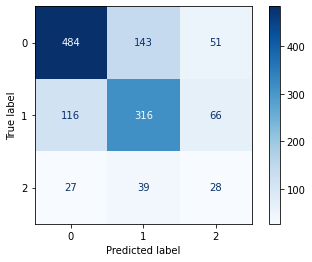

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_resampled, y_train_resampled)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       678
           1       0.67      0.67      0.67       498
           2       0.29      0.20      0.24        94

    accuracy                           0.71      1270
   macro avg       0.58      0.56      0.56      1270
weighted avg       0.70      0.71      0.70      1270

0.5582538526666763


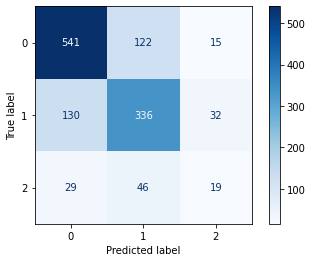

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
X_train_features= LBP_statistics_features_train
X_test_features= LBP_statistics_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
#Data Balancing in order to tackle data imbalance. technique used: SMOTE 
ros = SMOTE(sampling_strategy='auto', random_state= 42)
X_train_resampled, y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
print(np.bincount(y_train_resampled))

[2713 2713 2713]


First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_resampled, y_train_resampled)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.76      0.48      0.59       678
           1       0.56      0.51      0.53       498
           2       0.13      0.52      0.20        94

    accuracy                           0.50      1270
   macro avg       0.48      0.50      0.44      1270
weighted avg       0.63      0.50      0.54      1270

0.5036921677798875


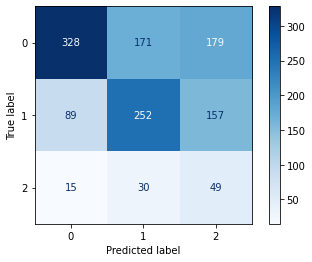

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_resampled, y_train_resampled)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.53      0.60       678
           1       0.56      0.46      0.50       498
           2       0.13      0.48      0.20        94

    accuracy                           0.50      1270
   macro avg       0.46      0.49      0.44      1270
weighted avg       0.60      0.50      0.53      1270

0.4891760602946526


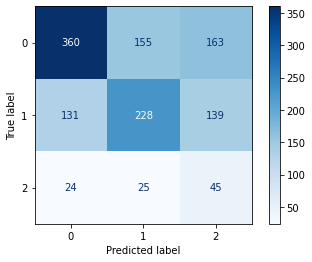

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_resampled, y_train_resampled)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       678
           1       0.57      0.55      0.56       498
           2       0.15      0.45      0.23        94

    accuracy                           0.55      1270
   macro avg       0.49      0.52      0.48      1270
weighted avg       0.64      0.55      0.58      1270

0.5226019246760467


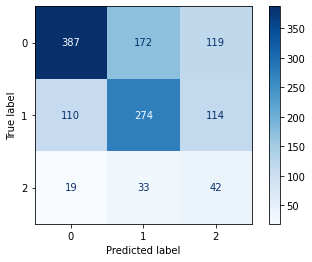

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_resampled, y_train_resampled)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       678
           1       0.63      0.59      0.61       498
           2       0.19      0.28      0.22        94

    accuracy                           0.63      1270
   macro avg       0.52      0.53      0.52      1270
weighted avg       0.65      0.63      0.64      1270

0.5279237832520064


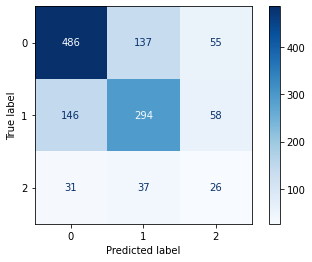

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_resampled, y_train_resampled)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56       678
           1       0.54      0.52      0.53       498
           2       0.12      0.46      0.19        94

    accuracy                           0.48      1270
   macro avg       0.46      0.48      0.43      1270
weighted avg       0.60      0.48      0.52      1270

0.48008175298318734


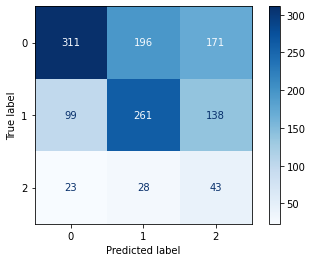

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_resampled, y_train_resampled)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.66      0.59      0.63       678
           1       0.54      0.52      0.53       498
           2       0.10      0.21      0.14        94

    accuracy                           0.53      1270
   macro avg       0.44      0.44      0.43      1270
weighted avg       0.58      0.53      0.55      1270

0.440583522819074


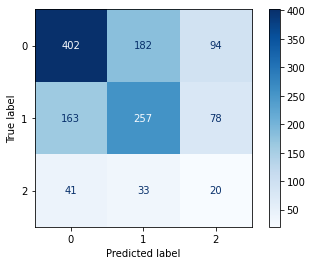

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_resampled, y_train_resampled)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       678
           1       0.57      0.57      0.57       498
           2       0.20      0.20      0.20        94

    accuracy                           0.60      1270
   macro avg       0.48      0.48      0.48      1270
weighted avg       0.60      0.60      0.60      1270

0.4826416694204169


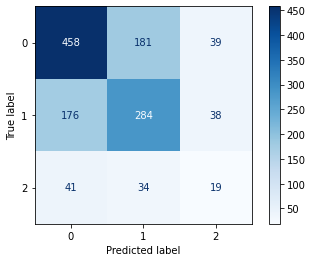

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_resampled, y_train_resampled)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.58      0.13      0.21       678
           1       0.44      0.36      0.39       498
           2       0.08      0.57      0.13        94

    accuracy                           0.25      1270
   macro avg       0.36      0.35      0.24      1270
weighted avg       0.49      0.25      0.27      1270

0.3530915225579403


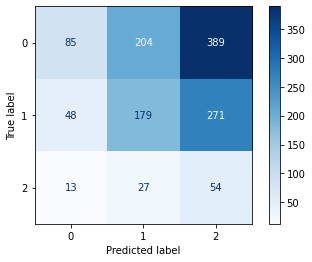

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_resampled, y_train_resampled)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64       678
           1       0.58      0.56      0.57       498
           2       0.14      0.39      0.20        94

    accuracy                           0.55      1270
   macro avg       0.49      0.51      0.47      1270
weighted avg       0.63      0.55      0.58      1270

0.5070571623089357


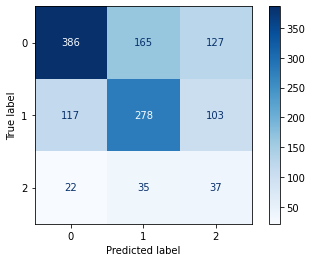

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_resampled, y_train_resampled)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       678
           1       0.64      0.60      0.62       498
           2       0.17      0.32      0.22        94

    accuracy                           0.63      1270
   macro avg       0.52      0.54      0.52      1270
weighted avg       0.67      0.63      0.64      1270

0.5379440311928692


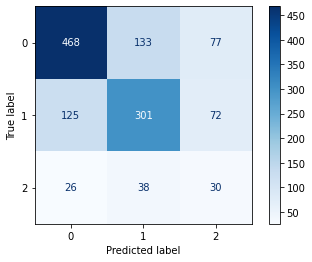

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_resampled, y_train_resampled)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       678
           1       0.62      0.61      0.62       498
           2       0.20      0.23      0.21        94

    accuracy                           0.64      1270
   macro avg       0.52      0.52      0.52      1270
weighted avg       0.65      0.64      0.65      1270

0.5235603809829162


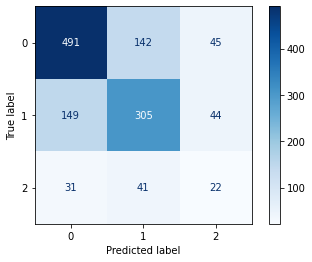

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()